Wholesale Price Model Evaluation:
Mean Squared Error: 6.38
Mean Absolute Error: 2.18
R-squared Score: 0.01


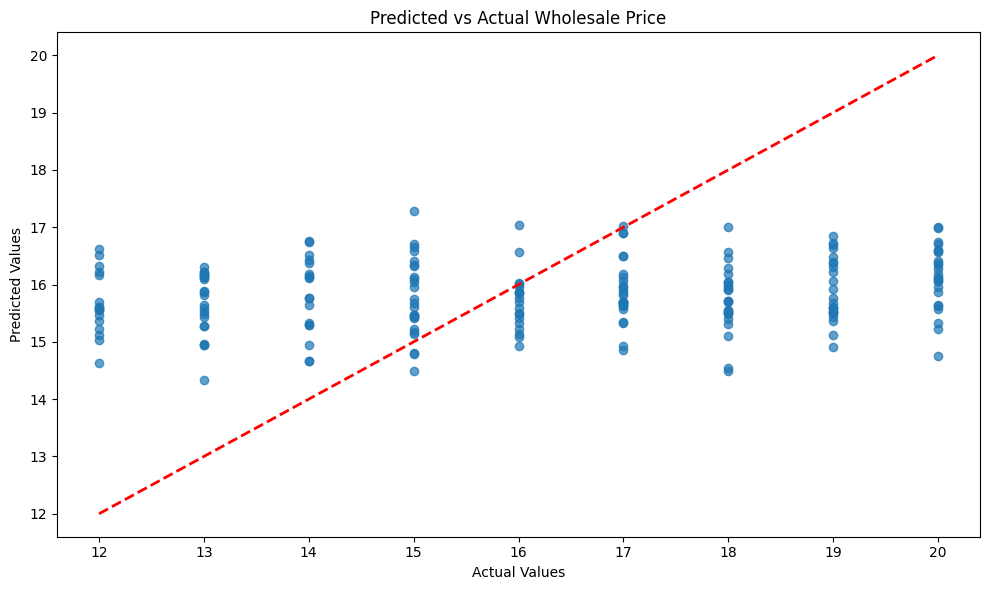

Domestic Consumption Model Evaluation:
Mean Squared Error: 2011513913.99
Mean Absolute Error: 38695.65
R-squared Score: -0.03


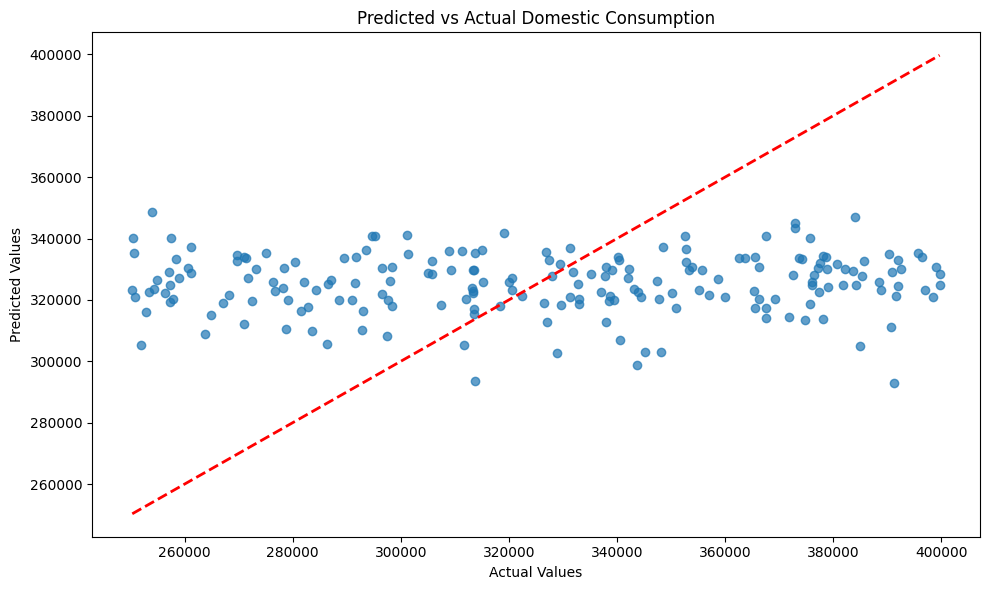

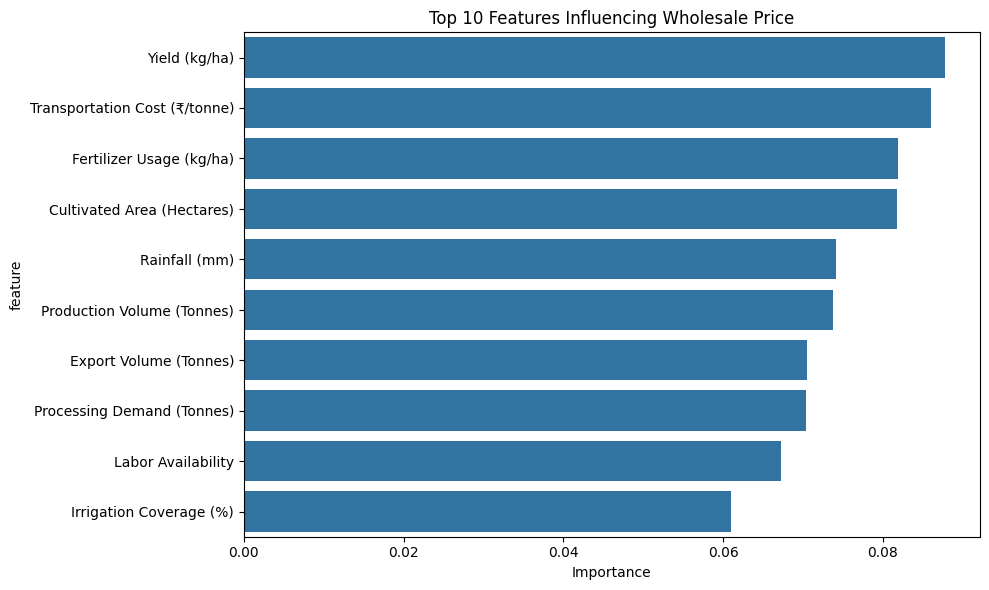

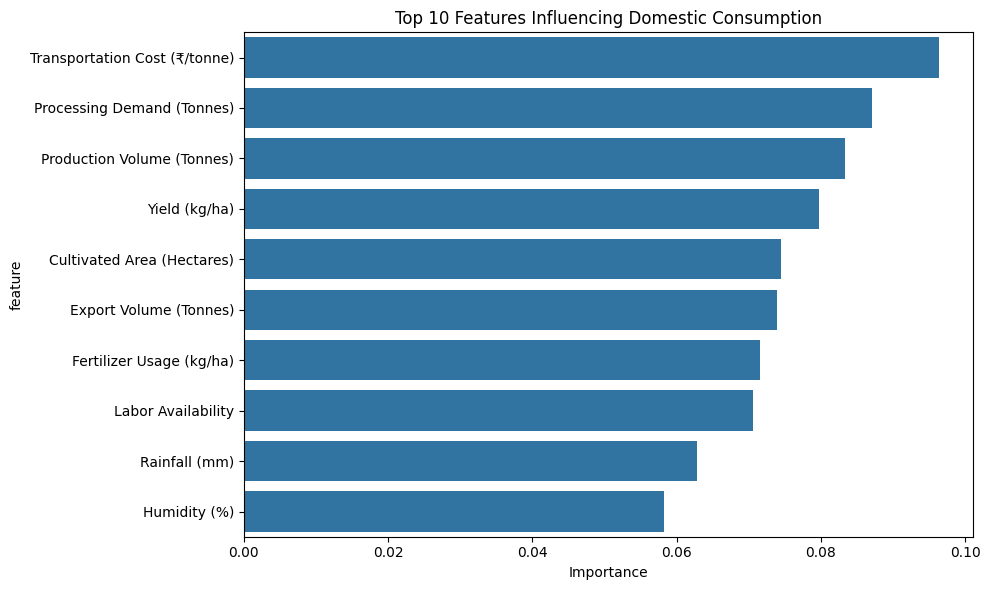

Predicted Wholesale Prices: [15.59]
Predicted Domestic Consumption: [356772.64]


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare the data
class MarketPriceDemandForecaster:
    def __init__(self, data):
        """
        Initialize the forecaster with agricultural market data
        
        Parameters:
        -----------
        data : pandas.DataFrame
            DataFrame containing market and agricultural features
        """
        self.original_data = data.copy()
        self.prepare_data()
    
    def prepare_data(self):
        """
        Preprocess the data for machine learning
        """
        # One-hot encode categorical variables
        categorical_cols = ['Region', 'Season', 'Seed Type', 'Storage Availability']
        self.data = pd.get_dummies(self.original_data, columns=categorical_cols)
        
        # Separate features and targets
        self.target_columns = ['Wholesale Price (₹/kg)', 'Domestic Consumption (Tonnes)']
        
        # Select features (excluding direct target variables)
        feature_columns = [
            col for col in self.data.columns 
            if col not in self.target_columns and 
            col not in categorical_cols
        ] + [col for col in self.data.columns if col.startswith(tuple(categorical_cols))]
        
        self.X = self.data[feature_columns]
        self.y_wholesale_price = self.data['Wholesale Price (₹/kg)']
        self.y_domestic_consumption = self.data['Domestic Consumption (Tonnes)']
    
    def train_models(self, test_size=0.2, random_state=42):
        """
        Train machine learning models for price and demand prediction
        
        Parameters:
        -----------
        test_size : float, optional (default=0.2)
            Proportion of the dataset to include in the test split
        random_state : int, optional (default=42)
            Controls the shuffling applied to the data before splitting
        """
        # Scale the features
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(self.X)
        
        # Split the data
        X_train, X_test, y_price_train, y_price_test, y_demand_train, y_demand_test = train_test_split(
            X_scaled, 
            self.y_wholesale_price, 
            self.y_domestic_consumption, 
            test_size=test_size, 
            random_state=random_state
        )
        
        # Train Random Forest models
        self.price_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        self.demand_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        
        self.price_model.fit(X_train, y_price_train)
        self.demand_model.fit(X_train, y_demand_train)
        
        # Evaluate models
        self._evaluate_model(
            self.price_model, X_test, y_price_test, 'Wholesale Price', 
            'Predicted vs Actual Wholesale Price'
        )
        self._evaluate_model(
            self.demand_model, X_test, y_demand_test, 'Domestic Consumption', 
            'Predicted vs Actual Domestic Consumption'
        )
    
    def _evaluate_model(self, model, X_test, y_test, target_name, plot_title):
        """
        Evaluate the model and create a scatter plot of predictions
        
        Parameters:
        -----------
        model : sklearn.BaseEstimator
            Trained machine learning model
        X_test : numpy.ndarray
            Test features
        y_test : numpy.ndarray
            Test target values
        target_name : str
            Name of the target variable for reporting
        plot_title : str
            Title for the evaluation plot
        """
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"{target_name} Model Evaluation:")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"R-squared Score: {r2:.2f}")
        
        # Scatter plot of predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.title(plot_title)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.tight_layout()
        plt.show()
    
    def feature_importance(self):
        """
        Analyze and visualize feature importance for both models
        """
        # Price model feature importance
        price_importances = pd.DataFrame({
            'feature': self.X.columns,
            'importance': self.price_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=price_importances.head(10))
        plt.title('Top 10 Features Influencing Wholesale Price')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        # Demand model feature importance
        demand_importances = pd.DataFrame({
            'feature': self.X.columns,
            'importance': self.demand_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=demand_importances.head(10))
        plt.title('Top 10 Features Influencing Domestic Consumption')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    
    def predict(self, new_data):
        """
        Make predictions for new data
        
        Parameters:
        -----------
        new_data : pandas.DataFrame
            New data for prediction (must have same feature structure)
        
        Returns:
        --------
        tuple: (predicted_prices, predicted_demand)
        """
        # Preprocess new data
        new_data_processed = pd.get_dummies(new_data)
        
        # Align columns with training data
        missing_cols = set(self.X.columns) - set(new_data_processed.columns)
        for col in missing_cols:
            new_data_processed[col] = 0
        new_data_processed = new_data_processed[self.X.columns]
        
        # Scale features
        new_data_scaled = self.scaler.transform(new_data_processed)
        
        # Predict
        predicted_prices = self.price_model.predict(new_data_scaled)
        predicted_demand = self.demand_model.predict(new_data_scaled)
        
        return predicted_prices, predicted_demand

# Example usage
def main():
    # Load the data (assuming you've read it from CSV or directly)
    data = pd.read_csv('tomato.csv')  # Replace with your actual data loading method
    
    # Initialize and train the forecaster
    forecaster = MarketPriceDemandForecaster(data)
    forecaster.train_models()
    
    # Analyze feature importance
    forecaster.feature_importance()
    
    # Example prediction (you'd replace this with actual new data)
    new_data = data.iloc[:1]  # Just an example, use actual new data
    predicted_prices, predicted_demand = forecaster.predict(new_data)
    
    print("Predicted Wholesale Prices:", predicted_prices)
    print("Predicted Domestic Consumption:", predicted_demand)

if __name__ == '__main__':
    main()